In [40]:
import kaggler
print(kaggler.__version__)
from kaggler.preprocessing import LabelEncoder
from kaggler.model import AutoLGB

ModuleNotFoundError: No module named 'kaggler'

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import lightgbm as lgb
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from tensorflow import keras
import warnings
from tqdm import tqdm

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectPercentile

In [2]:
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
warnings.simplefilter('ignore')

### Load Data

In [3]:
feature_name = 'ae'
algo_name = 'lgb'
model_name = f'{algo_name}_{feature_name}'

feature_file = f'{feature_name}.csv'
predict_val_file = f'{model_name}.val.txt'
predict_tst_file = f'{model_name}.tst.txt'
submission_file = f'{model_name}.sub.csv'

index_col = 'index'
target_col = 'credit'

In [5]:
trn = pd.read_csv('./train.csv', index_col=index_col)
print(trn.shape)
trn.head()

(26457, 19)


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
index,,,,,,,,,,,,,,,,,,,
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [6]:
tst = pd.read_csv('./test.csv', index_col=index_col)
print(tst.shape)
tst.head()

(10000, 18)


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
index,,,,,,,,,,,,,,,,,,
26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [7]:
sub = pd.read_csv('./sample_submission.csv', index_col=index_col)
print(sub.shape)
sub.head()

(10000, 3)


,0,1,2
index,,,
26457,0,0,0
26458,0,0,0
26459,0,0,0
26460,0,0,0
26461,0,0,0


### Simple EDA

In [8]:
trn[target_col] = trn[target_col].astype('category')
trn[target_col]

index
0        1.0
1        1.0
2        2.0
3        0.0
4        2.0
        ... 
26452    1.0
26453    2.0
26454    2.0
26455    2.0
26456    2.0
Name: credit, Length: 26457, dtype: category
Categories (3, float64): [0.0, 1.0, 2.0]

In [9]:
for col in trn.columns:
    print(f'{col:>16s}: {trn[col].count()}\t{trn[col].nunique()}\t{trn[col].dtype}')

          gender: 26457	2	object
             car: 26457	2	object
         reality: 26457	2	object
       child_num: 26457	9	int64
    income_total: 26457	249	float64
     income_type: 26457	5	object
        edu_type: 26457	5	object
     family_type: 26457	5	object
      house_type: 26457	6	object
      DAYS_BIRTH: 26457	6621	int64
   DAYS_EMPLOYED: 26457	3470	int64
      FLAG_MOBIL: 26457	1	int64
      work_phone: 26457	2	int64
           phone: 26457	2	int64
           email: 26457	2	int64
      occyp_type: 18286	18	object
     family_size: 26457	10	float64
     begin_month: 26457	61	float64
          credit: 26457	3	category


### Feature Engineering

In [10]:
trn = pd.read_csv('./train.csv', index_col=index_col)
tst = pd.read_csv('./test.csv', index_col=index_col)

In [11]:
trn.drop('FLAG_MOBIL', axis=1, inplace=True)
tst.drop('FLAG_MOBIL', axis=1, inplace=True)

In [12]:
trn.shape, tst.shape

((26457, 18), (10000, 17))

#### Numerical Features

국가기밀

In [13]:
trn['National']=0
nat = list(trn[trn.DAYS_EMPLOYED ==365243].index)

for i in range(0,26457):
    if i in nat:
        trn.loc[i,'National']=1

In [14]:
tst['National']=0
nat = list(tst[tst.DAYS_EMPLOYED ==365243].index)

for i in range(0,26457):
    if i in nat:
        tst.loc[i,'National']=1

절대값을 씌운다

In [15]:
trn['DAYS_BIRTH']=abs(trn['DAYS_BIRTH'])
trn['begin_month']=abs(trn['begin_month'])
trn['DAYS_EMPLOYED']=abs(trn['DAYS_EMPLOYED'])
tst['DAYS_BIRTH']=abs(tst['DAYS_BIRTH'])
tst['begin_month']=abs(tst['begin_month'])
tst['DAYS_EMPLOYED']=abs(tst['DAYS_EMPLOYED'])

In [16]:
trn['DAYS_EMPLOYED'] = trn['DAYS_EMPLOYED'].replace(365243, 0)
tst['DAYS_EMPLOYED'] = tst['DAYS_EMPLOYED'].replace(365243, 0)

시계열을 더욱 더 다루어보자

In [17]:
trn['child_ratio'] = trn['child_num'] / trn['family_size']

trn['begin_credit_year'] = (trn['begin_month']//12)
trn['begin_credit_day']= (trn['begin_month']*30)

# DAYS_BIRTH
trn['DAYS_BIRTH_year'] = trn['DAYS_BIRTH'] // 365 ## 나이
trn['DAYS_BIRTH_Aday'] = trn['DAYS_BIRTH'] % 365 ## 생일 일자
trn['DAYS_BIRTH_year2'] = trn['DAYS_BIRTH'] / 365
trn['DAYS_BIRTH_month']=trn['DAYS_BIRTH_Aday'].apply(lambda x: 1 if (x <31) else 2 if(x <59) else 3 if(x <90) else 4 if(x <120)
                                                    else 5 if(x <151) else 6 if(x <181) else 7 if(x <212) else 8 if(x <243) else 9 if(x <273)
                                                    else 10 if(x <304) else 11 if(x <334) else 12 )

trn['DAYS_BIRTH_day']=trn['DAYS_BIRTH_Aday'].apply(lambda x: x+1 if (x <31) else x-30 if(x <59) else x-58 if(x <90) else x-89 if(x <120)
                                                    else x-119 if(x <151) else x-150 if(x <181) else x-180 if(x <212) else x-211 if(x <243) else x-242 if(x <273)
                                                    else x-272 if(x <304) else x-303 if(x <334) else x-333 )

trn['DAYS_BIRTH_week'] = np.floor((trn['DAYS_BIRTH'])/7)-((np.floor((trn['DAYS_BIRTH'])/7)/4).astype(int)*4)

# DAYS_EMPLOYED - 업무를 진행한 일자
trn['DAYS_EMPLOYED_year'] = trn['DAYS_EMPLOYED'] / 365
trn['DAYS_EMPLOYED_month'] = trn['DAYS_EMPLOYED'] / 30
trn['DAYS_EMPLOYED_week'] = np.floor((trn['DAYS_EMPLOYED'])/7)-((np.floor((trn['DAYS_EMPLOYED'])/7)/4).astype(int)*4)

trn['EMPLOYED_START']=trn['DAYS_BIRTH_year'] -trn['DAYS_EMPLOYED_year']

trn['mean_income_family'] = trn['income_total'] / trn['family_size']
trn['income_day'] = trn['income_total'] /(trn['DAYS_EMPLOYED']+1)
trn['income_month'] = trn['income_total'] /(trn['DAYS_EMPLOYED_month']+1)
trn['income_year'] = trn['income_total'] /(trn['DAYS_EMPLOYED_year']+1)


trn['income_begin_ratio'] = (trn['begin_credit_year']) / trn['income_total']
trn['family_age_ratio'] = trn['DAYS_BIRTH_year'] / trn['family_size']
trn['family_income_ratio'] = trn['income_day'] / trn['family_size']
trn['family_child_abstract'] = trn['family_size'] - trn['child_num']
trn['income>mean'] = trn['income_day'].apply(lambda x: 1 if x>=trn['income_day'].mean() else 0)
trn['begin_month>mean'] = trn['begin_month'].apply(lambda x: 1 if x>=trn['begin_month'].mean() else 0)

# before_EMPLOYED
trn['before_EMPLOYED'] = trn['DAYS_BIRTH']-trn['DAYS_EMPLOYED']
trn['before_EMPLOYED_age'] = trn['before_EMPLOYED']//365
trn['before_EMPLOYED_month'] = trn['before_EMPLOYED']//30
trn['before_EMPLOYED_week'] = trn['before_EMPLOYED']//7

trn['before_EMPLOYED_BIRTH_ratio'] = trn['before_EMPLOYED'] / trn['DAYS_BIRTH']
trn['before_EMPLOYED_ratio'] = trn['before_EMPLOYED'] / (trn['DAYS_EMPLOYED']+1)
trn['before_EMPLOYED>mean'] = trn['before_EMPLOYED'].apply(lambda x: 1 if x>=trn['before_EMPLOYED'].mean() else 0)

In [18]:
tst['child_ratio'] = tst['child_num'] / tst['family_size']

tst['begin_credit_year'] = (tst['begin_month']//12)
tst['begin_credit_day']= (tst['begin_month']*30)

# DAYS_BIRTH
tst['DAYS_BIRTH_year'] = tst['DAYS_BIRTH'] // 365
tst['DAYS_BIRTH_Aday'] = tst['DAYS_BIRTH'] % 365
tst['DAYS_BIRTH_year2'] = tst['DAYS_BIRTH'] / 365
tst['DAYS_BIRTH_month']=tst['DAYS_BIRTH_Aday'].apply(lambda x: 1 if (x <31) else 2 if(x <59) else 3 if(x <90) else 4 if(x <120)
                                                    else 5 if(x <151) else 6 if(x <181) else 7 if(x <212) else 8 if(x <243) else 9 if(x <273)
                                                    else 10 if(x <304) else 11 if(x <334) else 12 )

tst['DAYS_BIRTH_day']=tst['DAYS_BIRTH_Aday'].apply(lambda x: x+1 if (x <31) else x-30 if(x <59) else x-58 if(x <90) else x-89 if(x <120)
                                                    else x-119 if(x <151) else x-150 if(x <181) else x-180 if(x <212) else x-211 if(x <243) else x-242 if(x <273)
                                                    else x-272 if(x <304) else x-303 if(x <334) else x-333 )

tst['DAYS_BIRTH_week'] = np.floor((tst['DAYS_BIRTH'])/7)-((np.floor((tst['DAYS_BIRTH'])/7)/4).astype(int)*4)

# DAYS_EMPLOYED
tst['DAYS_EMPLOYED_year'] = tst['DAYS_EMPLOYED'] / 365
tst['DAYS_EMPLOYED_month'] = tst['DAYS_EMPLOYED'] / 30
tst['DAYS_EMPLOYED_week'] = np.floor((-tst['DAYS_EMPLOYED'])/7)-((np.floor((-tst['DAYS_EMPLOYED'])/7)/4).astype(int)*4)

tst['EMPLOYED_START']=tst['DAYS_BIRTH_year'] -tst['DAYS_EMPLOYED_year']

tst['mean_income_family'] = tst['income_total'] / tst['family_size']
tst['income_day'] = tst['income_total'] / (tst['DAYS_EMPLOYED']+1)
tst['income_month'] = tst['income_total'] /(tst['DAYS_EMPLOYED_month']+1)
tst['income_year'] = tst['income_total'] /(tst['DAYS_EMPLOYED_year']+1)


tst['income_begin_ratio'] = (tst['begin_credit_year']) / tst['income_total']
tst['family_age_ratio'] = tst['DAYS_BIRTH_year'] / tst['family_size']
tst['family_income_ratio'] = tst['income_day'] / tst['family_size']
tst['family_child_abstract'] = tst['family_size'] - tst['child_num']
tst['income>mean'] = tst['income_day'].apply(lambda x: 1 if x>=tst['income_day'].mean() else 0)
tst['begin_month>mean'] = tst['begin_month'].apply(lambda x: 1 if x>=tst['begin_month'].mean() else 0)

# before_EMPLOYED
tst['before_EMPLOYED'] = tst['DAYS_BIRTH']-tst['DAYS_EMPLOYED']
tst['before_EMPLOYED_age'] = tst['before_EMPLOYED']//365
tst['before_EMPLOYED_month'] = tst['before_EMPLOYED']//30
tst['before_EMPLOYED_week'] = tst['before_EMPLOYED']//7

tst['before_EMPLOYED_BIRTH_ratio'] = tst['before_EMPLOYED'] / tst['DAYS_BIRTH']
tst['before_EMPLOYED_ratio'] = tst['before_EMPLOYED'] / (tst['DAYS_EMPLOYED']+1)
tst['before_EMPLOYED>mean'] = tst['before_EMPLOYED'].apply(lambda x: 1 if x>=tst['before_EMPLOYED'].mean() else 0)

In [19]:
trn['National_age']=trn['National']/trn['DAYS_BIRTH_year']
tst['National_age']=tst['National']/tst['DAYS_BIRTH_year']

In [20]:
trn['age_group'] = pd.cut(trn['DAYS_BIRTH_year2'], bins=[20, 30, 40, 50, 60, 70],
                         labels=['20ager', '30ager', '40ager', '50ager', '60ager'])

tst['age_group'] = pd.cut(tst['DAYS_BIRTH_year2'], bins=[20, 30, 40, 50, 60, 70],
                         labels=['20ager', '30ager', '40ager', '50ager', '60ager'])

In [21]:
trn = pd.concat([trn, pd.get_dummies(trn['age_group'])], axis=1)
tst = pd.concat([tst, pd.get_dummies(tst['age_group'])], axis=1)

In [22]:
trn['dup']=0
du = list(trn[trn.duplicated(keep=False)].index)

for i in range(0,26457):
    if i in du:
        trn.loc[i,'dup']=1

In [23]:
tst['dup']=0
du = list(tst[tst.duplicated(keep=False)].index)

for i in range(26457,36457):
    if i in du:
        tst.loc[i,'dup']=1

<AxesSubplot:ylabel='Frequency'>

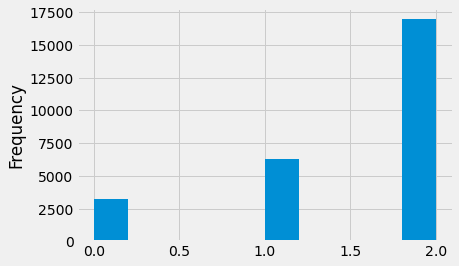

In [24]:
trn.credit.plot.hist()

In [25]:
#trn3 = trn.groupby(['income_total', 'income_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED'])['begin_month'].agg([('begin_month_sum', 'sum')])
#trn3 = pd.DataFrame(trn3)

#tst3 = tst.groupby(['income_total', 'income_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED'])['begin_month'].agg([('begin_month_sum', 'sum')])
#tst3 = pd.DataFrame(tst3)

In [26]:
#trn = trn.merge(trn3, how='left', on=('income_total', 'income_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED'))
#tst = tst.merge(tst3, how='left', on=('income_total', 'income_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED'))

In [27]:
#trn['begin_month_mean'] = -trn['begin_month_sum'] / trn['duplicated']
#tst['begin_month_mean'] = -tst['begin_month_sum'] / tst['duplicated']

In [28]:
trn.shape, tst.shape

((26457, 57), (10000, 56))

####  Encoding for Categorical Features

In [29]:
cat_cols = [x for x in trn.columns if trn[x].dtype == 'object']
num_cols = [x for x in trn.columns if x not in cat_cols + [target_col]]

feature_cols = num_cols + cat_cols
print(len(feature_cols), len(cat_cols), len(num_cols))

56 8 48


In [30]:
trn['occyp_type'] = trn['occyp_type'].fillna('no job')
tst['occyp_type'] = tst['occyp_type'].fillna('no job')

In [31]:
trn['income_occyp_type'] = trn['income_type'].astype(str) + "_" + trn['occyp_type'].astype(str)
tst['income_occyp_type'] = tst['income_type'].astype(str) + "_" + tst['occyp_type'].astype(str)

In [32]:
trn['income_age_type'] = trn['income_type'].astype(str) + "_" + trn['age_group'].astype(str)
tst['income_age_type'] = tst['income_type'].astype(str) + "_" + tst['age_group'].astype(str)
trn.drop('age_group', axis=1, inplace=True)
tst.drop('age_group', axis=1, inplace=True)

In [33]:
trn['edu_occyp_type'] = trn['edu_type'].astype(str) + "_" + trn['occyp_type'].astype(str)
tst['edu_occyp_type'] = tst['edu_type'].astype(str) + "_" + tst['occyp_type'].astype(str)

trn['edu_income_type'] = trn['edu_type'].astype(str) + "_" + trn['income_type'].astype(str)
tst['edu_income_type'] = tst['edu_type'].astype(str) + "_" + tst['income_type'].astype(str)

trn['family_income_type'] = trn['family_type'].astype(str) + "_" + trn['income_type'].astype(str)
tst['family_income_type'] = tst['family_type'].astype(str) + "_" + tst['income_type'].astype(str)

In [34]:
trn.income_age_type.isnull().sum()

0

In [35]:
def add_var(data):
    
    # 개개인을 구분할 수 있는 변수들을 묶어서 생성
    data['personal_id'] = data['gender'] + "_" + data['DAYS_BIRTH'].astype(str) + "_" + data['income_total'].astype(str) + "_" + data['income_type'].astype(str)
    
    # 카드를 생성한 기간도 같은 경우가 있어서 begin을 추가하여 하나의 변수를 더 생성
    data['personal_begin_id'] = data['gender'] + "_" + data['DAYS_BIRTH'].astype(str) + "_" + data['income_total'].astype(str) + "_" + data['income_type'].astype(str) + "_" + data['begin_month'].astype(str)
    
    # 그외의 변수들을 조합하여 하나의 변수로 추가 생성
    data['g_r_c'] = data['gender'] + "_" + data['reality'] + "_" + data['car'] 
    data['p_w_e'] = data['phone'].astype(str) + "_" + data['work_phone'].astype(str) + "_" + data['email'].astype(str) 
    
    return data

In [36]:
trn = add_var(trn)
tst = add_var(tst)

### word2vec

In [9]:
trn

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
index,,,,,,,,,,,,,,,,,,,
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0


In [11]:
# income_occyp_type, income_age_type, edu_occyp_type, edu_income_type, family_income_type

import random

train_data = list(trn.groupby('index')['income_occyp_type'].unique())
test_data = list(tst.groupby('index')['income_occyp_type'].unique())

In [12]:
train_data

[array(['Commercial associate'], dtype=object),
 array(['Commercial associate'], dtype=object),
 array(['Working'], dtype=object),
 array(['Commercial associate'], dtype=object),
 array(['State servant'], dtype=object),
 array(['Working'], dtype=object),
 array(['Working'], dtype=object),
 array(['Commercial associate'], dtype=object),
 array(['Commercial associate'], dtype=object),
 array(['Working'], dtype=object),
 array(['Working'], dtype=object),
 array(['Commercial associate'], dtype=object),
 array(['Commercial associate'], dtype=object),
 array(['Working'], dtype=object),
 array(['Pensioner'], dtype=object),
 array(['Working'], dtype=object),
 array(['Working'], dtype=object),
 array(['Commercial associate'], dtype=object),
 array(['Pensioner'], dtype=object),
 array(['Working'], dtype=object),
 array(['Working'], dtype=object),
 array(['Pensioner'], dtype=object),
 array(['Commercial associate'], dtype=object),
 array(['Working'], dtype=object),
 array(['Pensioner'], dtype=obj

In [573]:
def oversample(x, n):
    lst = []
    for i in x:
        tmp = []
        for j in range(n):
            random.shuffle(i)
            tmp += list(i)
            lst.append(tmp)
    return lst

In [574]:
w2v_input = oversample(train_data, 5)

In [575]:
from gensim.models import word2vec

w2v = word2vec.Word2Vec(sentences = w2v_input, size = 30, window = 3, min_count = 1, sg = 1)

In [576]:
train_mean_vector = []
for words in tqdm(train_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector.append(tmp)
train_mean_vector = np.array(train_mean_vector)

100%|█████████████████████████████████████████████████████████████████████████| 26457/26457 [00:00<00:00, 65454.17it/s]


In [577]:
test_mean_vector = []
for words in tqdm(test_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector.append(tmp)
test_mean_vector = np.array(test_mean_vector)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 46713.57it/s]


In [578]:
trn2 = trn.copy()
tst2 = tst.copy()
trn2 = trn2.reset_index()
tst2 = tst2.reset_index()

In [579]:
train_data = list(trn2.groupby('index')['income_age_type'].unique())
test_data = list(tst2.groupby('index')['income_age_type'].unique())

In [580]:
w2v_input = oversample(train_data, 5)

In [581]:
w2v = word2vec.Word2Vec(sentences = w2v_input, size = 30, window = 3, min_count = 1, sg = 1)

In [582]:
train_mean_vector2 = []
for words in tqdm(train_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector2.append(tmp)
train_mean_vector2 = np.array(train_mean_vector2)

100%|█████████████████████████████████████████████████████████████████████████| 26457/26457 [00:00<00:00, 65972.02it/s]


In [583]:
test_mean_vector2 = []
for words in tqdm(test_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector2.append(tmp)
test_mean_vector2 = np.array(test_mean_vector2)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 72448.49it/s]


In [37]:
trn['car_before>mean'] = trn['car'].astype(str) + "_" + trn['before_EMPLOYED>mean'].astype(str)
tst['car_before>mean'] = tst['car'].astype(str) + "_" + tst['before_EMPLOYED>mean'].astype(str)

trn['car_income>mean'] = trn['car'].astype(str) + "_" + trn['income>mean'].astype(str)
tst['car_income>mean'] = tst['car'].astype(str) + "_" + tst['income>mean'].astype(str)

trn['car_begin_month>mean'] = trn['car'].astype(str) + "_" + trn['begin_month>mean'].astype(str)
tst['car_begin_month>mean'] = tst['car'].astype(str) + "_" + tst['begin_month>mean'].astype(str)

trn['car_income_type'] = trn['car'].astype(str) + "_" + trn['income_type'].astype(str)
tst['car_income_type'] = tst['car'].astype(str) + "_" + tst['income_type'].astype(str)

trn['car_begin_month>mean_occyp'] = trn['car'].astype(str) + "_" + trn['begin_month>mean'].astype(str) + "_" + trn['occyp_type'].astype(str)
tst['car_begin_month>mean_occyp'] = tst['car'].astype(str) + "_" + tst['begin_month>mean'].astype(str) + "_" + tst['occyp_type'].astype(str)

In [38]:
trn['child_it']=trn['child_num'].apply(lambda x: 1 if x >0 else 0)
tst['child_it']=tst['child_num'].apply(lambda x: 1 if x >0 else 0)
trn['marry_child']='no'
tst['marry_child']='no'

In [39]:
trn.loc[trn[trn.family_type=='Separated'][trn.child_it==1].index,'marry_child']='sep_ch'
trn.loc[trn[trn.family_type=='Single / not married'][trn.child_it==1].index,'marry_child']='sin_ch'
trn.loc[trn[trn.family_type=='Widow'][trn.child_it==1].index,'marry_child']='wid_ch'

tst.loc[tst[tst.family_type=='Separated'][tst.child_it==1].index,'marry_child']='sep_ch'
tst.loc[tst[tst.family_type=='Single / not married'][tst.child_it==1].index,'marry_child']='sin_ch'
tst.loc[tst[tst.family_type=='Widow'][tst.child_it==1].index,'marry_child']='wid_ch'

In [40]:
trn.drop('child_it', axis=1, inplace=True)
tst.drop('child_it', axis=1, inplace=True)

In [41]:
cat_cols = [x for x in trn.columns if trn[x].dtype == 'object']
num_cols = [x for x in trn.columns if x not in cat_cols + [target_col]]

feature_cols = num_cols + cat_cols
print(len(feature_cols), len(cat_cols), len(num_cols))

70 23 47


In [42]:
trn.columns[trn.isnull().sum()>0]
tst.columns[tst.isnull().sum()>0]

Index([], dtype='object')

# 추가한 것

In [43]:
trn['contect']=trn['work_phone']+trn['phone']+trn['email']+1
tst['contect']=tst['work_phone']+tst['phone']+tst['email']+1

In [591]:
#trn['begin_birth']=trn.begin_month*trn.DAYS_BIRTH
#tst['begin_birth']=tst.begin_month*tst.DAYS_BIRTH

In [592]:
#trn['begin_birth_@']=trn.DAYS_BIRTH**trn.begin_month
#tst['begin_birth_@']=tst.DAYS_BIRTH**tst.begin_month

In [593]:
#trn['begin_EMPLOYED']=trn.begin_month*trn.DAYS_EMPLOYED
#tst['begin_EMPLOYED']=tst.begin_month*tst.DAYS_EMPLOYED

In [594]:
#trn['begin_EMPLOYED_@']=trn.DAYS_EMPLOYED**trn.begin_month
#tst['begin_EMPLOYED_@']=tst.DAYS_EMPLOYED**tst.begin_month

In [595]:
#trn['begin_before_EMPLOYED']=trn.begin_month*trn.before_EMPLOYED
#tst['begin_before_EMPLOYED']=tst.begin_month*tst.before_EMPLOYED

In [596]:
#trn['begin_before_EMPLOYED_@']=trn.before_EMPLOYED**trn.begin_month
#tst['begin_before_EMPLOYED_@']=tst.before_EMPLOYED**tst.begin_month

In [597]:
#trn['begin_before_EMPLOYED_BIRTH_ratio']=trn.begin_month*trn.before_EMPLOYED_BIRTH_ratio
#tst['begin_before_EMPLOYED_BIRTH_ratio']=tst.begin_month*tst.before_EMPLOYED_BIRTH_ratio

In [598]:
#trn['begin_before_EMPLOYED_BIRTH_ratio_@']=trn.before_EMPLOYED_BIRTH_ratio**trn.begin_month
#tst['begin_before_EMPLOYED_BIRTH_ratio_@']=tst.before_EMPLOYED_BIRTH_ratio**tst.begin_month

In [599]:
#trn['begin_before_EMPLOYED_ratio']=trn.begin_month*trn.before_EMPLOYED_ratio
#tst['begin_before_EMPLOYED_ratio']=tst.begin_month*tst.before_EMPLOYED_ratio

In [600]:
#trn['begin_before_EMPLOYED_ratio_@']=trn.before_EMPLOYED_ratio**trn.begin_month
#tst['begin_before_EMPLOYED_ratio_@']=tst.before_EMPLOYED_ratio**tst.begin_month

<AxesSubplot:>

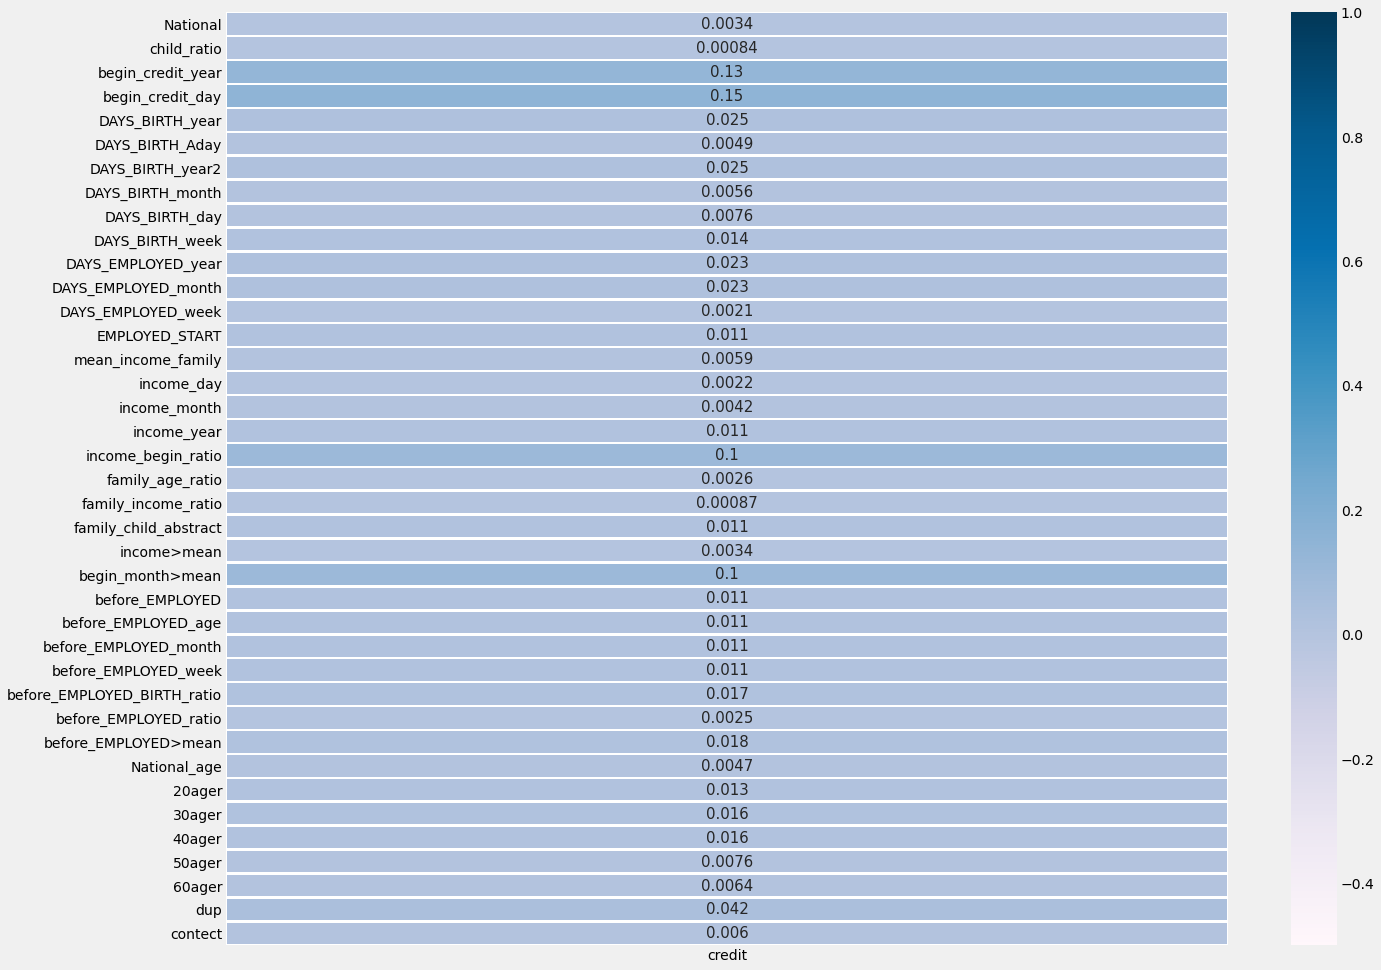

In [601]:
fig,ax=plt.subplots(figsize=(20,16))
colormap = plt.cm.PuBu 
sns.heatmap(abs(trn.corr()).iloc[9:10,10:].T, cmap=colormap, annot=True, vmin=-0.5, vmax=1, linewidths=1.5, annot_kws = {"size" : 15})

In [44]:
cat_cols = [x for x in trn.columns if trn[x].dtype == 'object']
num_cols = [x for x in trn.columns if x not in cat_cols + [target_col]]

feature_cols = num_cols + cat_cols
print(len(feature_cols), len(cat_cols), len(num_cols))

71 23 48


In [45]:
trn['income_total']=np.log1p(trn['income_total'])
tst['income_total']=np.log1p(tst['income_total'])
#############################################################

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
trn[num_cols] = scaler.fit_transform(trn[num_cols])
tst[num_cols] = scaler.transform(tst[num_cols])

In [605]:
#from sklearn.preprocessing import PolynomialFeatures
#poly = PolynomialFeatures(2, include_bias=True)

In [606]:
#trn_num=trn[num_cols]
#tst_num=tst[num_cols]

In [607]:
#trn_num = poly.fit_transform(trn_num)
#tst_num = poly.transform(tst_num)

In [608]:
#trn_num=pd.DataFrame(data=trn_num, columns=poly.get_feature_names())

In [609]:
#tst_num=pd.DataFrame(data=tst_num, columns=poly.get_feature_names())

In [610]:
#trn.drop(num_cols, axis=1, inplace=True)
#tst.drop(num_cols, axis=1, inplace=True)

In [47]:
from sklearn.preprocessing import LabelEncoder

In [48]:
lbe = LabelEncoder()

In [49]:
for i in cat_cols:
    trn[i]=lbe.fit_transform(trn[i])

In [50]:
for i in cat_cols:
    tst[i]=lbe.fit_transform(tst[i])

In [459]:
#trn[cat_cols] = lbe.fit_transform(trn[cat_cols])
#tst[cat_cols] = lbe.transform(tst[cat_cols])

In [460]:
#trn = pd.concat([trn, pd.get_dummies(trn[cat_cols])], axis=1)
#trn.drop(cat_cols, axis=1, inplace=True)

In [461]:
#tst = pd.concat([tst, pd.get_dummies(tst[cat_cols])], axis=1)
#tst.drop(cat_cols, axis=1, inplace=True)

In [619]:
train_mean_vector = pd.DataFrame(train_mean_vector)
train_mean_vector.index = trn.index
trn = pd.concat([trn, train_mean_vector], axis=1)

test_mean_vector = pd.DataFrame(test_mean_vector)
test_mean_vector.index = tst.index
tst = pd.concat([tst, test_mean_vector], axis=1)

In [622]:
train_mean_vector2 = pd.DataFrame(train_mean_vector2)
train_mean_vector2.index = trn.index
trn = pd.concat([trn, train_mean_vector2], axis=1)

test_mean_vector2 = pd.DataFrame(test_mean_vector2)
test_mean_vector2.index = tst.index
tst = pd.concat([tst, test_mean_vector2], axis=1)

In [533]:
#tst_num.set_index(tst.index,inplace=True)

In [534]:
#trn = pd.concat([trn, trn_num], axis=1)
#tst = pd.concat([tst, tst_num], axis=1)

In [535]:
#trn[num_cols] = np.log1p(trn[num_cols])
#tst[num_cols] = np.log1p(trn[num_cols])

In [51]:
y = trn[target_col]
n_trn = trn.shape[0]
X = trn.drop(target_col, axis=1)
X_tst = tst

In [52]:
y=y.reset_index()

In [53]:
y.drop('index',axis=1,inplace=True)

In [54]:
X_tst.fillna(0,inplace=True)

In [55]:
X.shape, X_tst.shape, y.shape

((26457, 71), (10000, 71), (26457, 1))

In [56]:
target=y

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from tqdm import tqdm
# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectPercentile

from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [08:07<00:00,  5.14s/it]

(33, -0.7400816454106227)


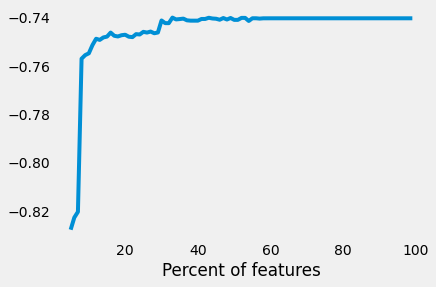

In [58]:
# 학습용과 제출용 데이터로 분리
features = pd.concat([X, X_tst], axis=0)
X_train = X
X_test = X_tst

# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LGBMClassifier(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    #X_new = SelectPercentile(percentile=p).fit_transform(X_train, target)    #SelectPercentile: 지정된 비율만큼 특성을 선택한다.
    X_new = RFE(model, n_features_to_select=p, step=10).fit_transform(X_train, target)
    cv_score = cross_val_score(model, X_new, target, scoring='neg_log_loss', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [59]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
#fs = SelectPercentile(percentile=best_score[0]).fit(X_train, y)
#X_train = fs.transform(X_train)
#X_test = fs.transform(X_test)
fs = RFE(estimator=LGBMClassifier(random_state=0), n_features_to_select=best_score[0], step=10)
X_train = fs.fit_transform(X_train, target)
X_test = fs.transform(X_test)

print(X_train.shape)
print(features.columns[fs.get_support()].tolist())

(26457, 33)
['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'occyp_type', 'begin_month', 'DAYS_BIRTH_year', 'DAYS_BIRTH_Aday', 'DAYS_BIRTH_day', 'DAYS_BIRTH_week', 'DAYS_EMPLOYED_week', 'EMPLOYED_START', 'mean_income_family', 'income_day', 'income_month', 'income_year', 'income_begin_ratio', 'family_age_ratio', 'family_income_ratio', 'before_EMPLOYED', 'before_EMPLOYED_BIRTH_ratio', 'National_age', 'dup', 'income_occyp_type', 'income_age_type', 'edu_occyp_type', 'edu_income_type', 'family_income_type', 'personal_id', 'personal_begin_id', 'g_r_c', 'p_w_e', 'car_income_type', 'car_begin_month>mean_occyp']


### Model Training

#### 5-fold Cross Validation + AutoLGB

In [637]:
X_train.shape,X_test.shape,target.shape

((26457, 96), (10000, 96), (26457, 1))

In [313]:
n_class = 3
n_fold = 5

params = {'num_class': n_class}

cv = StratifiedKFold(n_splits=n_fold)

p = np.zeros((X.shape[0], n_class), dtype=float)
p_tst = np.zeros((X_tst.shape[0], n_class), dtype=float)
for i_cv, (i_trn, i_val) in enumerate(cv.split(X, y)):
    if i_cv == 0:
        clf = AutoLGB(objective='multiclass', metric='multi_logloss', params=params, 
                      feature_selection=False, n_est=10000)
        clf.tune(X.iloc[i_trn], y[i_trn])
        n_best = clf.n_best
        features = clf.features
        params = clf.params
        print(f'best iteration: {n_best}')
        print(f'selected features ({len(features)}): {features}')        
        pprint(params)
        clf.fit(X.iloc[i_trn], y[i_trn])
    else:
        train_data = lgb.Dataset(X[features].iloc[i_trn], label=y[i_trn])
        clf = lgb.train(params, train_data, n_best, verbose_eval=100)
    
    p[i_val] = clf.predict(X[features].iloc[i_val])
    p_tst += clf.predict(X_tst[features]) / n_fold   # oof

IndexError: list index out of range

In [70]:
print(f'CV Log Loss: {log_loss(y, p):.6f}')
np.savetxt(predict_val_file, p, fmt='%.6f')
np.savetxt(predict_tst_file, p_tst, fmt='%.6f')

CV Log Loss: 1.098612


In [170]:
sub[sub.columns] = p_tst
sub.head()

,0,1,2
index,,,
26457,0.085760,0.171326,0.742913
26458,0.140151,0.160011,0.699838
26459,0.082076,0.118417,0.799507
26460,0.102079,0.142700,0.755221
26461,0.108594,0.167827,0.723579


In [33]:
sub.to_csv('0514(feature+w2v).csv')

#### LGBM 모델

In [60]:
ftr=X_train
target=y

In [61]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((18519, 33), (7938, 33))

In [62]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

In [63]:
clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric='logloss', 
        verbose=100, early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.762208	valid_1's multi_logloss: 0.790793
[200]	training's multi_logloss: 0.716007	valid_1's multi_logloss: 0.76951
[300]	training's multi_logloss: 0.68029	valid_1's multi_logloss: 0.755661
[400]	training's multi_logloss: 0.651267	valid_1's multi_logloss: 0.74592
[500]	training's multi_logloss: 0.626434	valid_1's multi_logloss: 0.738783
[600]	training's multi_logloss: 0.603786	valid_1's multi_logloss: 0.733891
[700]	training's multi_logloss: 0.582287	valid_1's multi_logloss: 0.728659
[800]	training's multi_logloss: 0.562608	valid_1's multi_logloss: 0.725181
[900]	training's multi_logloss: 0.543591	valid_1's multi_logloss: 0.721956
[1000]	training's multi_logloss: 0.525187	valid_1's multi_logloss: 0.71903
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.525187	valid_1's multi_logloss: 0.71903


LGBMClassifier(learning_rate=0.02, max_depth=12, n_estimators=1000,
               num_leaves=32, silent=-1, subsample=0.8, verbose=-1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

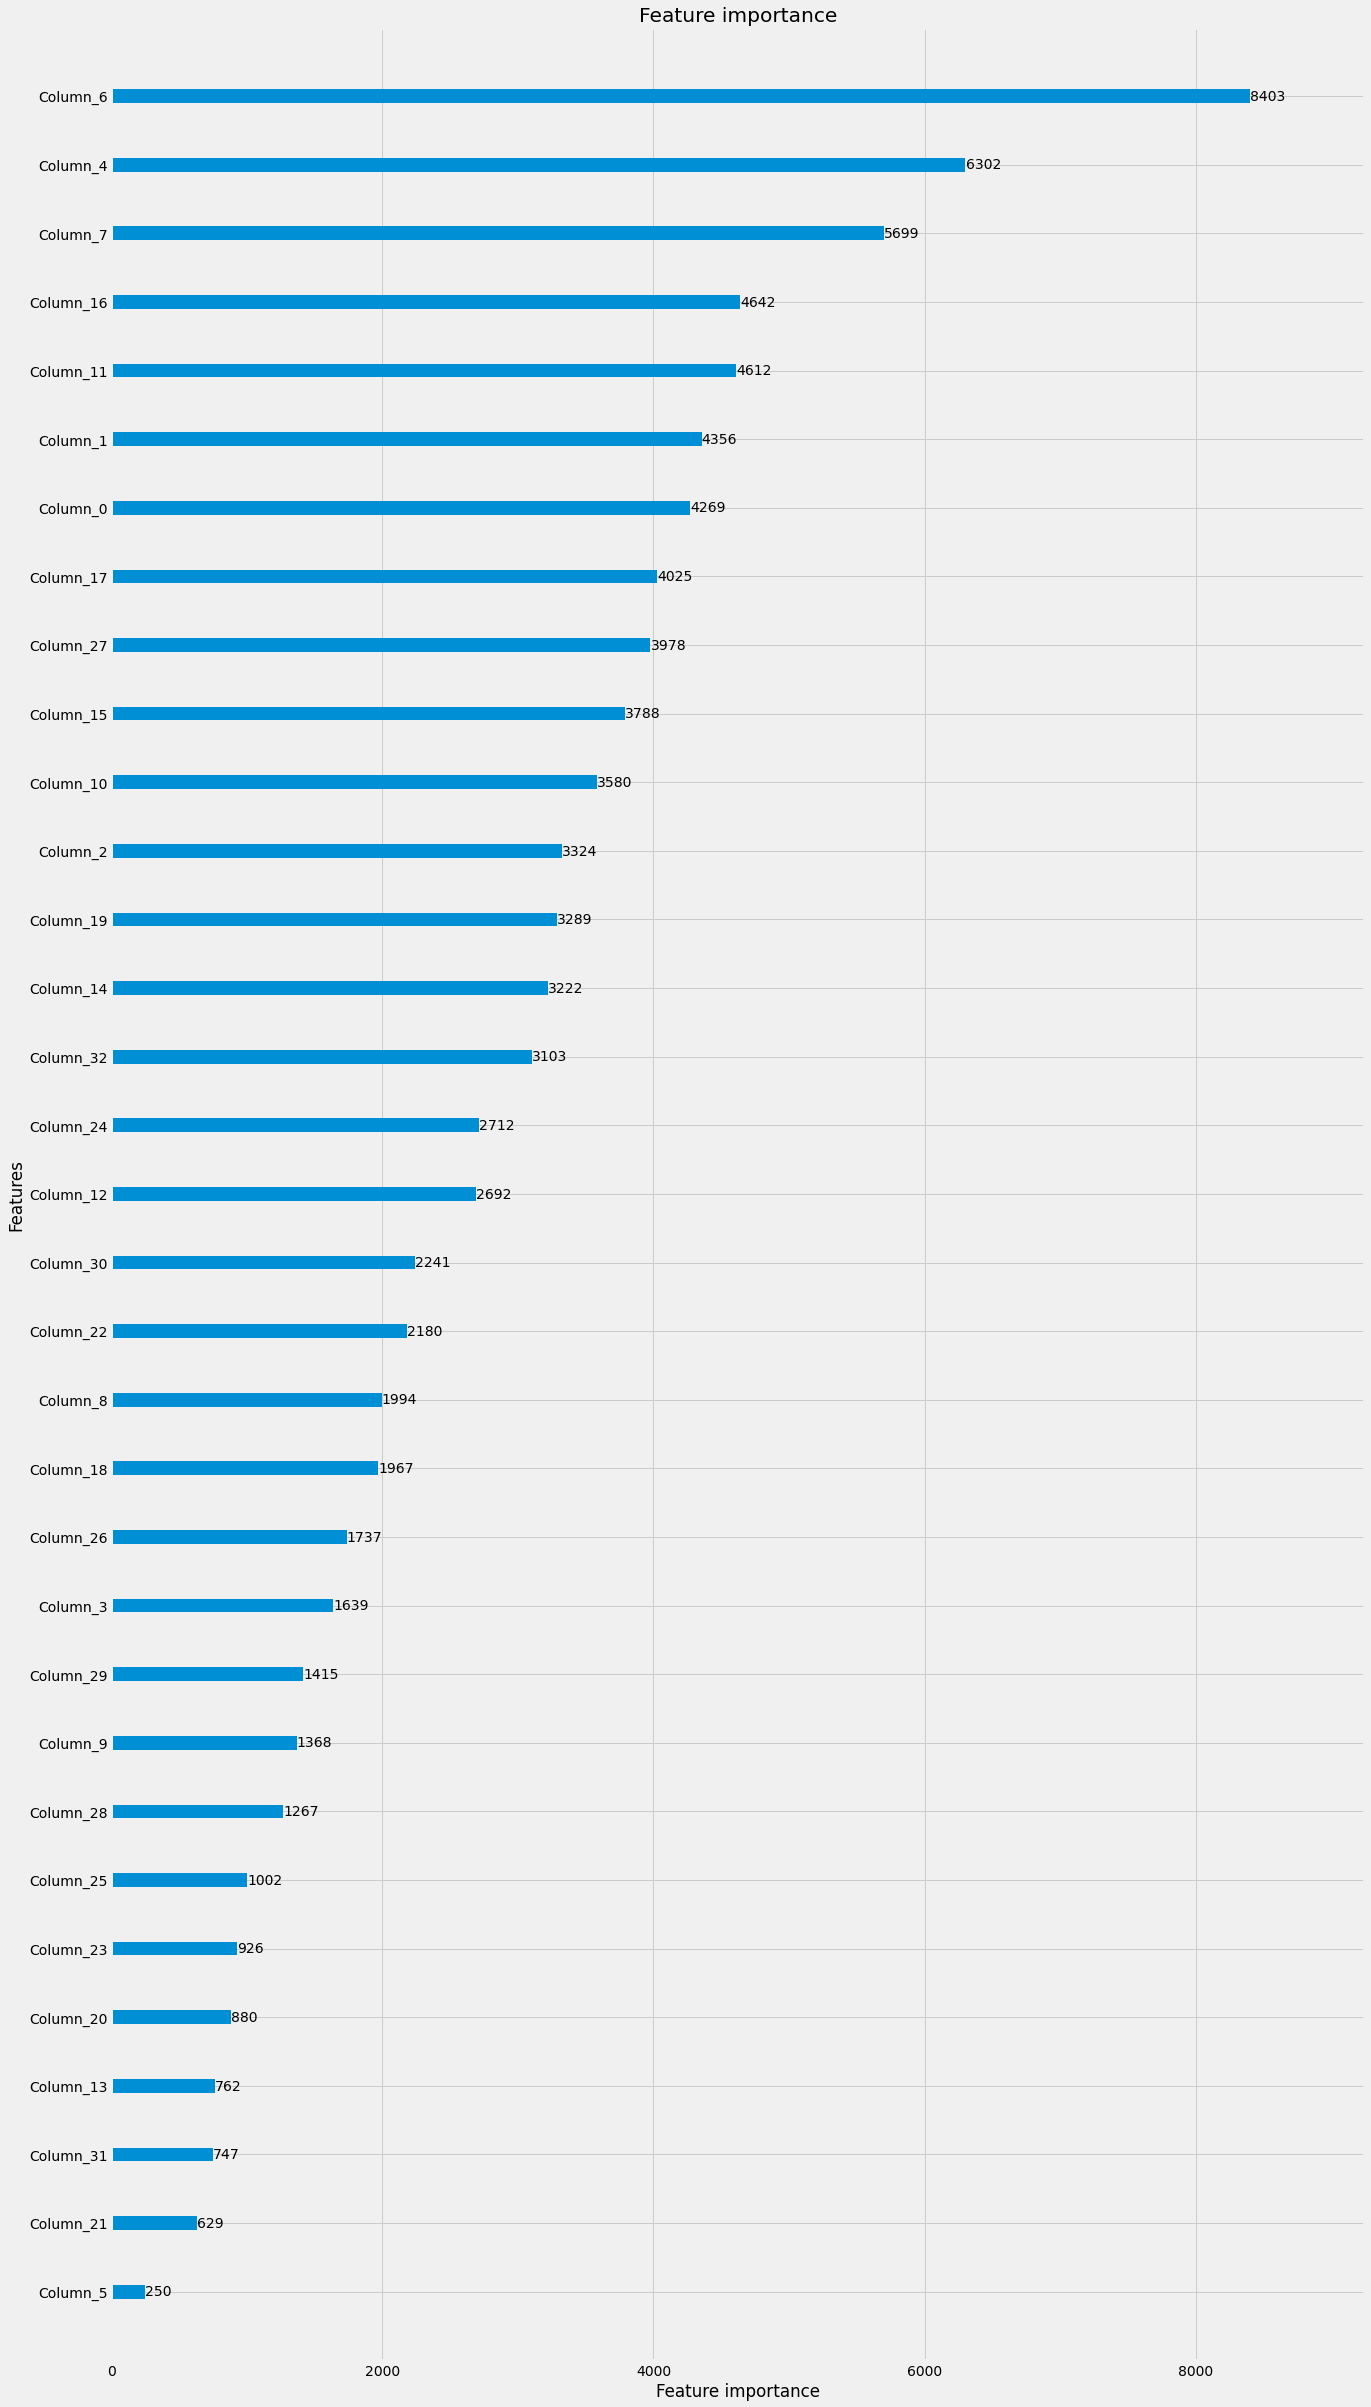

In [64]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(20, 40), max_num_features=200)

#### Feature Selection & Cross Validation

In [638]:
ftr=X_train
target=y

In [284]:
import time
from sklearn.feature_selection import SelectFromModel

start = time.time()

smf = SelectFromModel(clf, threshold='median')
smf.fit(ftr, target)
X_new = smf.transform(ftr)
X_te_new = smf.transform(X_tst)
feature_idx = smf.get_support()
feature_name = ftr.columns[feature_idx]

print("time :", time.time() - start)

time : 196.06027913093567


In [285]:
ftr.columns[feature_idx]

Index([                   'reality',                   'edu_type',
                       'occyp_type',          'income_occyp_type',
                   'edu_occyp_type',            'edu_income_type',
               'family_income_type',            'car_income_type',
       'car_begin_month>mean_occyp',                            0,
       ...
                            'x42^2',                    'x42 x44',
                          'x42 x45',                      'x44^2',
                          'x44 x45',                      'x45^2',
                          'x45 x47',                      'x46^2',
                          'x46 x47',                      'x47^2'],
      dtype='object', length=660)

In [286]:
X_new = pd.DataFrame(X_new)
X_te_new = pd.DataFrame(X_te_new)

X_new.columns = feature_name
X_te_new.columns = feature_name

In [287]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_new, target, scoring='neg_log_loss', cv=5)
print('교차 검증별 정확도:', np.round(scores, 4))
print('평균 검증 정확도:', np.round(np.mean(scores), 4))

교차 검증별 정확도: [-0.7056 -0.7137 -0.7191 -0.7171 -0.714 ]
평균 검증 정확도: -0.7139


#### Bayesian Opt

In [65]:
ftr = X_train

In [66]:
from bayes_opt import BayesianOptimization

In [67]:
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((18519, 33), (7938, 33))

In [68]:
bayesian_params = {
    'max_depth':(8, 16),
    'num_leaves':(24, 64),
    'min_child_samples':(10, 200),
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1),
    'colsample_bytree':(0.5, 1),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha':(0.01, 50)
}

In [69]:
def lgb_log_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree, max_bin, reg_lambda, reg_alpha):
    
    params = {
        "n_estimators":2000, 
        "learning_rate":0.02,
        'max_depth':int(round(max_depth)),
        'num_leaves':int(round(num_leaves)),
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample':max(min(subsample, 1), 0),
        'colsample_bytree':max(min(colsample_bytree, 1), 0),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    
    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric='logloss', verbose=100, 
                early_stopping_rounds=100)
    valid_pred = lgb_model.predict_proba(valid_x)
    log_score = log_loss(valid_y, valid_pred)
    
    return log_score

In [70]:
lgbBO = BayesianOptimization(f=lgb_log_eval, pbounds=bayesian_params, random_state=0)
lgbBO.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.803787	valid_1's multi_logloss: 0.809477
[200]	training's multi_logloss: 0.775699	valid_1's multi_logloss: 0.794218
[300]	training's multi_logloss: 0.756229	valid_1's multi_logloss: 0.786432
[400]	training's multi_logloss: 0.740576	valid_1's multi_logloss: 0.780151
[500]	training's multi_logloss: 0.729395	valid_1's multi_logloss: 0.776215
[600]	training's multi_logloss: 0.721677	valid_1's multi_logloss: 0.773782
[700]	training's multi_logloss: 0.714707	valid_1's multi_logloss: 0.771466
[800]	training's multi_logloss: 0.710688	valid_1's multi_logloss: 0.770247
[900]	training's multi_logloss: 0.708995	valid_1's multi_logloss: 0.76

[300]	training's multi_logloss: 0.766728	valid_1's multi_logloss: 0.789944
[400]	training's multi_logloss: 0.755031	valid_1's multi_logloss: 0.785038
[500]	training's multi_logloss: 0.746754	valid_1's multi_logloss: 0.782096
[600]	training's multi_logloss: 0.741031	valid_1's multi_logloss: 0.780046
[700]	training's multi_logloss: 0.739675	valid_1's multi_logloss: 0.779566
[800]	training's multi_logloss: 0.738617	valid_1's multi_logloss: 0.779191
[900]	training's multi_logloss: 0.738048	valid_1's multi_logloss: 0.778962
[1000]	training's multi_logloss: 0.737918	valid_1's multi_logloss: 0.778924
[1100]	training's multi_logloss: 0.737872	valid_1's multi_logloss: 0.778924
[1200]	training's multi_logloss: 0.737855	valid_1's multi_logloss: 0.778919
Early stopping, best iteration is:
[1117]	training's multi_logloss: 0.737856	valid_1's multi_logloss: 0.778918
|  6        |  0.7789   |  0.8603   |  261.4    |  10.34    |  67.91    |  41.57    |  42.94    |  25.9     |  3.527    |  0.6767   |
Tr

[100]	training's multi_logloss: 0.805687	valid_1's multi_logloss: 0.811946
[200]	training's multi_logloss: 0.775661	valid_1's multi_logloss: 0.795186
[300]	training's multi_logloss: 0.754007	valid_1's multi_logloss: 0.785644
[400]	training's multi_logloss: 0.736834	valid_1's multi_logloss: 0.779133
[500]	training's multi_logloss: 0.72303	valid_1's multi_logloss: 0.774415
[600]	training's multi_logloss: 0.711797	valid_1's multi_logloss: 0.77053
[700]	training's multi_logloss: 0.703947	valid_1's multi_logloss: 0.767863
[800]	training's multi_logloss: 0.698389	valid_1's multi_logloss: 0.766143
[900]	training's multi_logloss: 0.69611	valid_1's multi_logloss: 0.765399
[1000]	training's multi_logloss: 0.694697	valid_1's multi_logloss: 0.764979
[1100]	training's multi_logloss: 0.694204	valid_1's multi_logloss: 0.764869
[1200]	training's multi_logloss: 0.693934	valid_1's multi_logloss: 0.764798
[1300]	training's multi_logloss: 0.693715	valid_1's multi_logloss: 0.764768
[1400]	training's multi_

|  16       |  0.7398   |  0.7405   |  120.1    |  12.94    |  53.76    |  42.68    |  47.66    |  10.66    |  1.986    |  0.8184   |
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.817252	valid_1's multi_logloss: 0.818288
[200]	training's multi_logloss: 0.796516	valid_1's multi_logloss: 0.803988
[300]	training's multi_logloss: 0.783491	valid_1's multi_logloss: 0.796708
[400]	training's multi_logloss: 0.774368	valid_1's multi_logloss: 0.792241
[500]	training's multi_logloss: 0.768706	valid_1's multi_logloss: 0.789553
[600]	training's multi_logloss: 0.765852	valid_1's multi_logloss: 0.788151
[700]	training's multi_logloss: 0.763896	valid_1's multi_logloss: 0.787204
[800]	training's multi_logloss: 0.762966	valid_1's multi_logloss: 0.786731
[900]	training's multi_logloss: 0.762688	valid_1's multi_logloss: 0.786532
[1000]	training's multi_logloss: 0.762588	valid_1's multi_logloss: 0.786448
[1100]	training's multi_logloss: 0.762542	valid_1's m

[500]	training's multi_logloss: 0.789474	valid_1's multi_logloss: 0.797181
[600]	training's multi_logloss: 0.788726	valid_1's multi_logloss: 0.796639
[700]	training's multi_logloss: 0.788426	valid_1's multi_logloss: 0.796369
[800]	training's multi_logloss: 0.788247	valid_1's multi_logloss: 0.796239
[900]	training's multi_logloss: 0.788131	valid_1's multi_logloss: 0.796158
[1000]	training's multi_logloss: 0.788062	valid_1's multi_logloss: 0.7961
[1100]	training's multi_logloss: 0.788024	valid_1's multi_logloss: 0.796067
[1200]	training's multi_logloss: 0.787997	valid_1's multi_logloss: 0.796051
[1300]	training's multi_logloss: 0.787986	valid_1's multi_logloss: 0.796047
[1400]	training's multi_logloss: 0.78798	valid_1's multi_logloss: 0.796045
[1500]	training's multi_logloss: 0.787977	valid_1's multi_logloss: 0.796044
[1600]	training's multi_logloss: 0.787975	valid_1's multi_logloss: 0.796043
[1700]	training's multi_logloss: 0.787974	valid_1's multi_logloss: 0.796042
[1800]	training's mu

[600]	training's multi_logloss: 0.795384	valid_1's multi_logloss: 0.799296
[700]	training's multi_logloss: 0.795119	valid_1's multi_logloss: 0.799116
[800]	training's multi_logloss: 0.795084	valid_1's multi_logloss: 0.799073
[900]	training's multi_logloss: 0.79507	valid_1's multi_logloss: 0.799057
[1000]	training's multi_logloss: 0.795067	valid_1's multi_logloss: 0.799054
[1100]	training's multi_logloss: 0.795067	valid_1's multi_logloss: 0.799054
[1200]	training's multi_logloss: 0.795067	valid_1's multi_logloss: 0.799054
[1300]	training's multi_logloss: 0.795067	valid_1's multi_logloss: 0.799054
[1400]	training's multi_logloss: 0.795067	valid_1's multi_logloss: 0.799054
[1500]	training's multi_logloss: 0.795067	valid_1's multi_logloss: 0.799054
[1600]	training's multi_logloss: 0.795067	valid_1's multi_logloss: 0.799054
[1700]	training's multi_logloss: 0.795067	valid_1's multi_logloss: 0.799054
[1800]	training's multi_logloss: 0.795067	valid_1's multi_logloss: 0.799054
[1900]	training's

In [71]:
lgbBO.res

[{'target': 0.7691085159917602,
  'params': {'colsample_bytree': 0.7744067519636624,
   'max_bin': 360.44278952248555,
   'max_depth': 12.822107008573152,
   'min_child_samples': 113.52780476941041,
   'min_child_weight': 21.75908516760633,
   'num_leaves': 49.835764522666246,
   'reg_alpha': 21.884984691022,
   'reg_lambda': 8.917838234820016,
   'subsample': 0.9818313802505146}},
 {'target': 0.7300382577896942,
  'params': {'colsample_bytree': 0.6917207594128889,
   'max_bin': 397.94526866050563,
   'max_depth': 12.231159358023236,
   'min_child_samples': 117.92846660784714,
   'min_child_weight': 46.35423527634039,
   'num_leaves': 26.841442327915477,
   'reg_alpha': 4.36559369208002,
   'reg_lambda': 0.20316375600581688,
   'subsample': 0.916309922773969}},
 {'target': 0.7279155418271027,
  'params': {'colsample_bytree': 0.8890783754749252,
   'max_bin': 436.30595264094137,
   'max_depth': 15.828946737862111,
   'min_child_samples': 161.8401272011775,
   'min_child_weight': 23.6124

In [72]:
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('minimum target index:', np.argmin(np.array(target_list)))

[0.7691085159917602, 0.7300382577896942, 0.7279155418271027, 0.7809401451012024, 0.7907880180551838, 0.7789185358029416, 0.7993785764288135, 0.7993785764288135, 0.7988973052578966, 0.7684825731095013, 0.7646163836555849, 0.7735283607266036, 0.750332114189867, 0.7993356427344155, 0.7769696998838638, 0.7397586129661493, 0.7863445531506507, 0.7995918430083316, 0.7948897874357864, 0.7994922349434591, 0.7960416861840361, 0.7901808398285217, 0.7978211114716413, 0.7772244301277065, 0.7922039932078145, 0.7990538757283318, 0.7984347553728851, 0.7993785764288135, 0.7989567678170864, 0.7286795430877697]
minimum target index: 2


In [73]:
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
min_dict = lgbBO.res[np.argmin(np.array(target_list))]
print(min_dict)

{'target': 0.7279155418271027, 'params': {'colsample_bytree': 0.8890783754749252, 'max_bin': 436.30595264094137, 'max_depth': 15.828946737862111, 'min_child_samples': 161.8401272011775, 'min_child_weight': 23.61248875039366, 'num_leaves': 55.22116705145822, 'reg_alpha': 5.922538549187972, 'reg_lambda': 6.3995702922539115, 'subsample': 0.5716766437045232}}


In [74]:
X_train = pd.DataFrame(X_train)
X_train.columns = features.columns[fs.get_support()].tolist()

In [75]:
ftr = X_train
target=y

In [76]:
from sklearn.model_selection import KFold

def train_apps_all_with_oof(ftr, target, nfolds=5):

    # nfolds 개의 cross validatin fold set을 가지는 KFold 생성 
    folds = KFold(n_splits=nfolds, shuffle=True, random_state=0)
    
    # Out of Folds로 학습된 모델의 validation set을 예측하여 결과 확률을 담을 array 생성.
    # validation set가 n_split갯수만큼 있으므로 크기는 ftr_app의 크기가 되어야 함. 
    oof_preds = np.zeros(ftr.shape[0])
    
    # Ouf of Folds로 학습된 모델의 test dataset을 예측하여 결과 확률을 담을 array 생성. 
    test_preds = np.zeros((X_tst.shape[0], 3))
    
    # n_estimators를 4000까지 확대. 
    clf = LGBMClassifier(
                n_jobs=4,
                n_estimators=4000,
                learning_rate=0.01,
                max_depth=16,
                num_leaves=55,
                colsample_bytree=0.8891,
                subsample=0.5716,
                max_bin=436,
                reg_alpha=5.92,
                reg_lambda=6.399,
                min_child_weight=23.612,
                min_child_samples=162,
                silent=-1,
                verbose=-1,
                )
    
    # nfolds 번 cross validation Iteration 반복하면서 OOF 방식으로 학습 및 테스트 데이터 예측
    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(ftr)):
        print('##### iteration', fold_idx, '시작')
        # 학습용 데이터 세트의 인덱스와 검증용 데이터 세트의 인덱스 추출하여 이를 기반으로 학습/검증 데이터 추출
        train_x = ftr.iloc[train_idx,:]
        train_y = target.iloc[train_idx]
        valid_x = ftr.iloc[valid_idx,:]
        valid_y = target.iloc[valid_idx]
        
        # 추출된 학습/검증 데이터 세트로 모델 학습. early_stopping은 200으로 증가. 
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'logloss', verbose= 200, 
                early_stopping_rounds= 200)
        
        # 검증 데이터 세트로 예측된 확률 저장. 사용되지는 않음. 
        #oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]    
        
        # 학습된 모델로 테스트 데이터 세트에 예측 확률 계산.
        # nfolds 번 반복 실행하므로 평균 확률을 구하기 위해 개별 수행시 마다 수행 횟수로 나눈 확률을 추후에 더해서 최종 평균 확률 계산. 
        test_preds += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)/folds.n_splits
             
    return clf, test_preds

In [77]:
clf, test_preds = train_apps_all_with_oof(ftr, target, nfolds=5)

##### iteration 0 시작
Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 0.767674	valid_1's multi_logloss: 0.796599
[400]	training's multi_logloss: 0.716363	valid_1's multi_logloss: 0.773006
[600]	training's multi_logloss: 0.679353	valid_1's multi_logloss: 0.760104
[800]	training's multi_logloss: 0.648601	valid_1's multi_logloss: 0.749656
[1000]	training's multi_logloss: 0.623216	valid_1's multi_logloss: 0.741938
[1200]	training's multi_logloss: 0.602246	valid_1's multi_logloss: 0.737147
[1400]	training's multi_logloss: 0.583514	valid_1's multi_logloss: 0.73363
[1600]	training's multi_logloss: 0.566765	valid_1's multi_logloss: 0.730215
[1800]	training's multi_logloss: 0.551699	valid_1's multi_logloss: 0.727802
[2000]	training's multi_logloss: 0.537857	valid_1's multi_logloss: 0.725072
[2200]	training's multi_logloss: 0.525207	valid_1's multi_logloss: 0.723597
[2400]	training's multi_logloss: 0.513297	valid_1's multi_logloss: 0.722736
[2600]	tra

In [185]:
sub[sub.columns] = test_preds
sub.head()

,0,1,2
index,,,
26457,0.131130,0.193161,0.675710
26458,0.112663,0.139175,0.748162
26459,0.102797,0.115718,0.781485
26460,0.085845,0.153520,0.760636
26461,0.128029,0.196145,0.675826


In [186]:
sub.to_csv('0520_0.csv')

In [362]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32), max_num_features=100)

NotFittedError: No booster found. Need to call fit beforehand.

### TabNet

In [41]:
#!pip uninstall -y typing
#!pip install "git+https://github.com/dreamquark-ai/tabnet.git@develop#egg=pytorch_tabnet" --upgrade

In [29]:
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss

import pandas as pd
import numpy as np
np.random.seed(0)

from tqdm.notebook import tqdm

import os

from matplotlib import pyplot as plt
%matplotlib inline

In [43]:
ftr = X
target = y
train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((18519, 42), (7938, 42))

In [44]:
clf = TabNetMultiTaskClassifier(n_steps=12,
                                #cat_idxs=cat_idxs,
                                #cat_dims=cat_dims,
                                #cat_emb_dim=1,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=2e-2),
                                scheduler_params={"step_size":50,
                                                  "gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                mask_type='entmax',
                                lambda_sparse=0
                               )

Device used : cuda


In [45]:
train_y = train_y.values.reshape(-1, 1)
valid_y = valid_y.values.reshape(-1, 1)

In [46]:
train_y.shape, valid_y.shape

((18519, 1), (7938, 1))

In [47]:
max_epochs = 300
clf.fit(
    X_train=train_x.values, y_train=train_y,
    eval_set=[(train_x.values, train_y),(valid_x.values, valid_y)],
    max_epochs=max_epochs,
    patience=50, # please be patient ^^
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=1,
    drop_last=False,
    eval_metric=['logloss'],
)

epoch 0  | loss: 1.54238 | val_0_logloss: 1.16283 | val_1_logloss: 1.1599  |  0:00:14s
epoch 1  | loss: 1.00132 | val_0_logloss: 0.93277 | val_1_logloss: 0.93229 |  0:00:26s
epoch 2  | loss: 0.90455 | val_0_logloss: 0.90316 | val_1_logloss: 0.8952  |  0:00:38s
epoch 3  | loss: 0.8907  | val_0_logloss: 0.92451 | val_1_logloss: 0.92367 |  0:00:50s
epoch 4  | loss: 0.97504 | val_0_logloss: 0.92867 | val_1_logloss: 0.91954 |  0:01:02s
epoch 5  | loss: 0.90255 | val_0_logloss: 0.88677 | val_1_logloss: 0.87857 |  0:01:15s
epoch 6  | loss: 0.8854  | val_0_logloss: 0.90019 | val_1_logloss: 0.89381 |  0:01:27s
epoch 7  | loss: 0.89418 | val_0_logloss: 0.9742  | val_1_logloss: 0.97149 |  0:01:40s
epoch 8  | loss: 0.88304 | val_0_logloss: 0.871   | val_1_logloss: 0.86744 |  0:01:52s
epoch 9  | loss: 0.85851 | val_0_logloss: 0.85526 | val_1_logloss: 0.84756 |  0:02:04s
epoch 10 | loss: 0.8565  | val_0_logloss: 0.86605 | val_1_logloss: 0.86262 |  0:02:17s
epoch 11 | loss: 0.85841 | val_0_logloss: 0

KeyboardInterrupt: 

In [101]:
preds_valid = clf.predict_proba(valid_x) 

KeyError: 0

In [104]:
preds = clf.predict_proba(X_tst.values)

In [105]:
clf.feature_importances_

array([0.00000000e+00, 2.00849521e-07, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.24661225e-08, 2.89296739e-02, 4.96195230e-05,
       0.00000000e+00, 6.09123495e-03, 0.00000000e+00, 7.95918225e-03,
       2.87692345e-05, 0.00000000e+00, 6.52308535e-03, 1.77970344e-02,
       0.00000000e+00, 1.46755834e-04, 8.43464586e-05, 3.56562386e-03,
       5.07747956e-02, 2.63306682e-03, 3.68186585e-01, 4.55488098e-03,
       9.67713790e-05, 1.93876926e-03, 3.03110960e-05, 0.00000000e+00,
       1.35227044e-02, 1.20155367e-04, 1.65185043e-02, 0.00000000e+00,
       1.99645820e-02, 1.27087444e-02, 9.96006171e-04, 0.00000000e+00,
       9.99052425e-03, 3.52421556e-02, 6.54490846e-02, 7.57587974e-04,
       0.00000000e+00, 2.61295126e-01, 6.40433661e-02, 7.39197186e-07,
       0.00000000e+00])

In [107]:
preds

[array([[0.9184187 , 0.08158131],
        [0.9077851 , 0.09221484],
        [0.908599  , 0.09140091],
        ...,
        [0.91712284, 0.08287717],
        [0.91068983, 0.08931015],
        [0.8935914 , 0.10640858]], dtype=float32),
 array([[0.82641864, 0.17358135],
        [0.82653093, 0.17346905],
        [0.8144582 , 0.18554188],
        ...,
        [0.83056337, 0.16943662],
        [0.82116115, 0.17883888],
        [0.80011714, 0.19988288]], dtype=float32),
 array([[0.28532866, 0.7146714 ],
        [0.2833449 , 0.71665514],
        [0.2968669 , 0.7031331 ],
        ...,
        [0.27105832, 0.7289416 ],
        [0.29076704, 0.709233  ],
        [0.3025799 , 0.6974201 ]], dtype=float32)]

In [106]:
i, j, k = [], [], []
for row in range(10000):
  i.append(preds[0][row][0])
  j.append(preds[0][row][1])
  k.append(preds[0][row][2])

len(i), len(j), len(k)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
sub['0'] = i
sub['1'] = j
sub['2'] = k
sub.head(10)

In [ ]:
submission.to_csv("submisison_tabnet.csv",index=False)

In [ ]:
prediction = pd.read_csv('submisison_tabnet.csv')

In [ ]:
prediction

In [9]:
train = pd.read_csv('./open/train.csv')
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 


test = pd.read_csv('./open/test.csv')
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

submission = pd.read_csv('./open/sample_submission.csv')

In [10]:
data=pd.concat([train, test], axis=0)
data.shape

(36457, 19)

In [11]:
# 나이 변환
def days_to_age(x):
    return (x*-1)/365
data['DAYS_BIRTH'] = data['DAYS_BIRTH'].apply(days_to_age)

In [12]:
# 마이너스 값 변환
def minus(x):
    return x * -1
data['begin_month'] = data['begin_month'].apply(minus)

In [13]:
data.loc[(data.DAYS_EMPLOYED)>=0,'DAYS_EMPLOYED'] = 0

In [14]:
data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].apply(days_to_age)

In [15]:
data.loc[data['child_num'] >= 2,'child_num']=2

(2.544, 18.18]      22460
(18.18, 33.66]      11380
(33.66, 49.14]       2099
(49.14, 64.62]        274
(64.62, 80.1]         165
(80.1, 95.58]          58
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: income_total, dtype: int64


<AxesSubplot:ylabel='Frequency'>

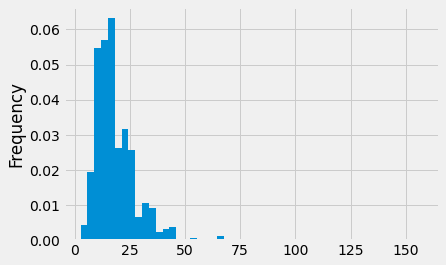

In [16]:
data['income_total'] = data['income_total'].astype(object)
data['income_total'] = data['income_total']/10000 
print(data['income_total'].value_counts(bins=10,sort=False))
data['income_total'].plot(kind='hist',bins=50,density=True)

In [17]:
count, bin_dividers =np.histogram(data['income_total'], bins=7)
bin_names=[int(i) for i in range(7) ]
data['income_total']=pd.cut(x=data['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)

In [18]:
data['gender'] = data['gender'].replace(['F','M'],[0,1])
print('gender :')
print(data['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
data['car'] = data['car'].replace(['N','Y'],[0,1])
print(data['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
data['reality'] = data['reality'].replace(['N','Y'],[0,1])
print(data['reality'].value_counts())
print('--------------')
      
print('Having a phone or not: ')
print(data['phone'].value_counts())
print('--------------')
      

print('Having a email or not: ')
print(data['email'].value_counts())
print('--------------')
      

print('Having a work phone or not: ')
print(data['work_phone'].value_counts())
print('--------------')

gender :
0    24430
1    12027
Name: gender, dtype: int64
--------------
Having a car or not : 
0    22614
1    13843
Name: car, dtype: int64
--------------
Having house reality or not: 
1    24506
0    11951
Name: reality, dtype: int64
--------------
Having a phone or not: 
0    25709
1    10748
Name: phone, dtype: int64
--------------
Having a email or not: 
0    33186
1     3271
Name: email, dtype: int64
--------------
Having a work phone or not: 
0    28235
1     8222
Name: work_phone, dtype: int64
--------------


In [19]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
data['income_type']=label_encoder.fit_transform(data['income_type'])
data['edu_type']=label_encoder.fit_transform(data['edu_type'])
data['family_type']=label_encoder.fit_transform(data['family_type'])
data['house_type']=label_encoder.fit_transform(data['house_type'])
data['income_total']=label_encoder.fit_transform(data['income_total'])
data['occyp_type']=label_encoder.fit_transform(data['occyp_type'])

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         36457 non-null  int64  
 1   car            36457 non-null  int64  
 2   reality        36457 non-null  int64  
 3   child_num      36457 non-null  int64  
 4   income_total   36457 non-null  int64  
 5   income_type    36457 non-null  int32  
 6   edu_type       36457 non-null  int32  
 7   family_type    36457 non-null  int32  
 8   house_type     36457 non-null  int32  
 9   DAYS_BIRTH     36457 non-null  float64
 10  DAYS_EMPLOYED  36457 non-null  float64
 11  FLAG_MOBIL     36457 non-null  int64  
 12  work_phone     36457 non-null  int64  
 13  phone          36457 non-null  int64  
 14  email          36457 non-null  int64  
 15  occyp_type     36457 non-null  int32  
 16  family_size    36457 non-null  float64
 17  begin_month    36457 non-null  float64
 18  credit 

In [21]:
train=data[:len(data)-10000]
test=data[len(data)-10000:]

In [22]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test.drop('credit', axis=1)

In [23]:
np.random.seed(42)
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(train.shape[0],))

train_indices = train_x[train.Set=="train"].index
valid_indices = train_x[train.Set=="valid"].index

In [24]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in tqdm(train_x.columns):
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train_x[col].nunique())
        l_enc = LabelEncoder()
        train_x[col] = train_x[col].fillna("NaN")
        train_x[col] = l_enc.fit_transform(train_x[col].values)
        try:
            test_x[col] = test_x[col].fillna("NaN")
            test_x[col] = l_enc.transform(test_x[col].values)
        except:
            print(f"Column {col} does not exist in test set")
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        training_mean = train_x.loc[train_indices, col].mean()
        train.fillna(training_mean, inplace=True)
        test.fillna(training_mean, inplace=True)

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]


gender 2


IndexError: tuple index out of range

In [25]:
features = [ col for col in train_x.columns] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [26]:
X_train = train_x[features].values[train_indices]
y_train = train_y.values[train_indices]

X_valid = train_x[features].values[valid_indices]
y_valid = train_y.values[valid_indices]

X_test = test_x[features].values

In [27]:
y_train.shape

(21162, 1)

In [31]:
clf = TabNetMultiTaskClassifier(n_steps=10,
                                cat_idxs=cat_idxs,
                                cat_dims=cat_dims,
                                cat_emb_dim=1,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=2e-2),
                                scheduler_params={"step_size":50,
                                                  "gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                mask_type='entmax',
                                lambda_sparse=0
                      )

Device used : cuda


In [32]:
max_epochs = 100
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train),(X_valid, y_valid)],
    max_epochs=max_epochs,
    patience=50, # please be patient ^^
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=1,
    drop_last=False,
    eval_metric=['logloss'],
    number_
    
)

epoch 0  | loss: 1.17452 | val_0_logloss: 1.64308 | val_1_logloss: 1.63053 |  0:00:14s
epoch 1  | loss: 0.92306 | val_0_logloss: 1.21081 | val_1_logloss: 1.23865 |  0:00:25s
epoch 2  | loss: 0.89149 | val_0_logloss: 0.99126 | val_1_logloss: 0.99743 |  0:00:38s
epoch 3  | loss: 0.87843 | val_0_logloss: 0.89099 | val_1_logloss: 0.88887 |  0:00:50s
epoch 4  | loss: 0.85262 | val_0_logloss: 0.8999  | val_1_logloss: 0.90133 |  0:01:02s
epoch 5  | loss: 0.83605 | val_0_logloss: 0.89854 | val_1_logloss: 0.8985  |  0:01:15s
epoch 6  | loss: 0.83619 | val_0_logloss: 0.88601 | val_1_logloss: 0.88949 |  0:01:27s
epoch 7  | loss: 0.83111 | val_0_logloss: 0.87639 | val_1_logloss: 0.87923 |  0:01:39s
epoch 8  | loss: 0.82582 | val_0_logloss: 0.84692 | val_1_logloss: 0.84857 |  0:01:51s


KeyboardInterrupt: 